In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
from pathlib import Path
from datetime import datetime
from matplotlib import pyplot as plt
import datetime

In [2]:
from scipy.stats import shapiro
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import boxcox

In [3]:
%matplotlib inline

#### Read in data

In [4]:
data_path = "D:\\Users\\Nicholas\\Projects\\repos\\spc_charts\\data\\raw\\dengue"

#### Read in pre-2012

In [5]:
data0 = pd.read_csv(Path(data_path) / 'dengue-pre2012.csv')

In [6]:
data0 = data0[2:].copy()

In [7]:
data0['week'] = list(range(1,53))*12
data0['year'] = [i for i in list(range(2000, 2012)) for _ in range(52)]
data0 = data0.drop('time', axis=1)

#### Read in pre-2012

In [8]:
post_files = os.listdir(Path(data_path) / 'dengue-post2012')

In [9]:
data = pd.DataFrame()

In [10]:
for i in range(len(post_files)):
    temp = pd.read_csv(Path(data_path) / 'dengue-post2012' / post_files[i])
    temp['year'] = os.path.splitext(post_files[i])[0]
    data = pd.concat([data, temp], axis=0, ignore_index=True)

In [11]:
data.columns = ['week', 'cases', 'year']

In [12]:
data = pd.concat([data0, data], axis=0, ignore_index=True, sort=True)

In [13]:
data['datetime'] = data['year'].astype('str') + '-' + data['week'].astype('str')

In [14]:
data['datetime'] = data['datetime'].apply(lambda x: datetime.datetime.strptime(x + '-1', "%Y-%W-%w"))
data['datetime'] = pd.to_datetime(data['datetime'])

#### Read in pop

In [15]:
pop = pd.read_csv(Path(data_path) / 'population-sg.csv')

In [16]:
pop['population'] = pop['population'].str.replace(',', '').astype('float')

In [17]:
data['year'] = data['year'].astype('int64')

In [18]:
data = data.merge(pop, on='year', how='left')

In [19]:
data['norm_cases'] = data['cases'] / data['population'] * 1000000

In [20]:
data

,cases,week,year,datetime,population,norm_cases
0,15,1,2000,2000-01-03,4027887.0,3.724037
1,15,2,2000,2000-01-10,4027887.0,3.724037
2,13,3,2000,2000-01-17,4027887.0,3.227499
3,19,4,2000,2000-01-24,4027887.0,4.717113
4,5,5,2000,2000-01-31,4027887.0,1.241346
...,...,...,...,...,...,...
1031,242,43,2019,2019-10-28,5703569.0,42.429573
1032,308,44,2019,2019-11-04,5703569.0,54.001275
1033,322,45,2019,2019-11-11,5703569.0,56.455879
1034,373,46,2019,2019-11-18,5703569.0,65.397648


#### Plot

D:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


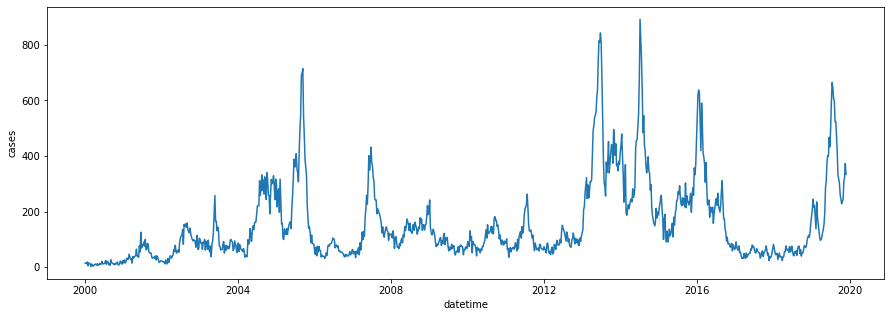

In [21]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='datetime', y='cases', data=data, kind='line', ax=ax)
plt.close()

#### Get subset of data

In [22]:
data_filter = (data['datetime'] >= '2008') & (data['datetime'] < '2014')

In [23]:
in_control_filter = (data['datetime'] >= '2008') & (data['datetime'] < '2013')

In [24]:
cutoff = '2013'

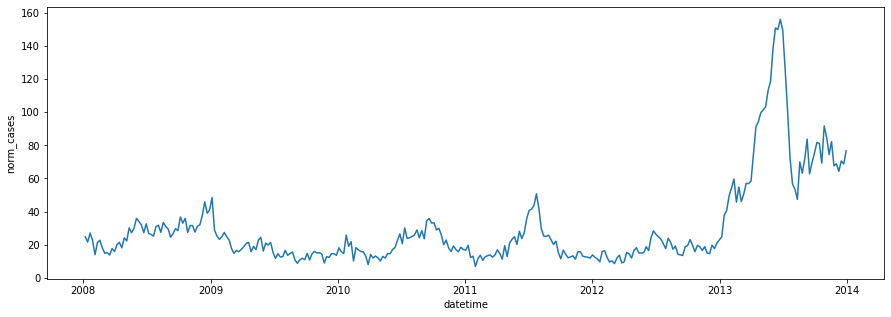

In [25]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='datetime', y='norm_cases', data=data[data_filter], kind='line', ax=ax)
plt.close()

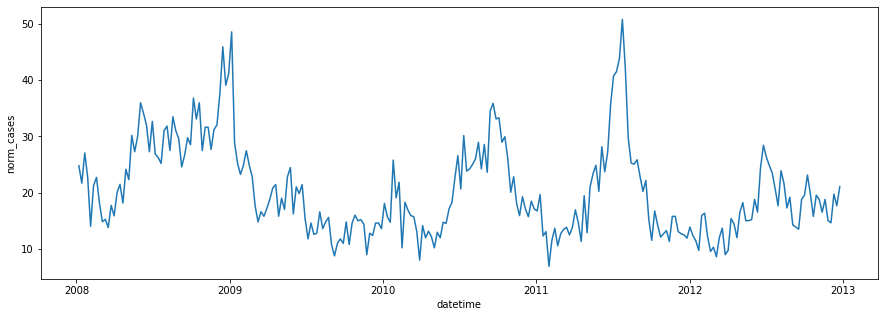

In [26]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='datetime', y='norm_cases', data=data[in_control_filter], kind='line', ax=ax)
plt.close()

#### Hypothesis test

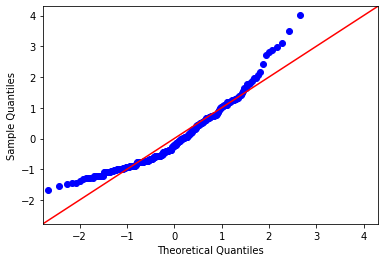

In [27]:
fig = sm.qqplot(data.loc[in_control_filter, 'cases'], fit=True, line='45')
plt.show()

In [28]:
def shapiro_wilks_(data, alpha):
    
    # Imports
    from scipy.stats import shapiro
    
    # normality test
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    
    # interpret
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [29]:
shapiro_wilks_(data.loc[in_control_filter, 'cases'], alpha=0.05)

Statistics=0.928, p=0.000
Sample does not look Gaussian (reject H0)


In [30]:
def jarque_bera_(data, alpha):
    
    # imports
    import statsmodels
    
    # normality test
    stat, p, skew, kurt = statsmodels.stats.stattools.jarque_bera(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    
    # interpret
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [31]:
jarque_bera_(data.loc[in_control_filter, 'cases'], alpha=0.05)

Statistics=65.356, p=0.000
Sample does not look Gaussian (reject H0)


#### Assume negative-binomial distribution with conditional mean

In [32]:
from statsmodels.discrete.discrete_model import NegativeBinomial
import math

In [33]:
# build model matrix
X = data.loc[data_filter, ['datetime', 'norm_cases']]
X = X.reset_index(drop=True).reset_index()
X['week'] = X['datetime'].dt.week
X['month'] = X['datetime'].dt.month

In [34]:
X['cos_week'] = X['week'].apply(lambda x: math.cos(2 * math.pi * x / 52))
X['sin_week'] = X['week'].apply(lambda x: math.sin(2 * math.pi * x / 52))
X['cos_month'] = X['month'].apply(lambda x: math.cos(2 * math.pi * x / 12))
X['sin_month'] = X['month'].apply(lambda x: math.sin(2 * math.pi * x / 12))

In [35]:
variables = ['index', 'cos_week', 'sin_week', 'cos_month', 'sin_month', 'norm_cases']

In [36]:
train = X.loc[X['datetime'] < cutoff, variables]
test = X.loc[X['datetime'] >= cutoff, variables]

#### fit model

In [37]:
model = smf.glm(formula = "norm_cases ~ index + cos_week + sin_week + cos_month + sin_month", 
                data=train, 
                family=sm.families.NegativeBinomial(alpha = 1))

results = model.fit()

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             norm_cases   No. Observations:                  260
Model:                            GLM   Df Residuals:                      254
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1044.8
Date:                Sun, 08 Mar 2020   Deviance:                       26.129
Time:                        00:33:18   Pearson chi2:                     27.4
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2400      0.128     25.367      0.000       2.990       3.490
index         -0.0019      0.001     -2.211      0.027      -0.004      -0.000
cos_week      -0.4107      0.574     -0.716      0.474      -1.536       0.714
sin_week      -0.0351      0.581     -0.060      0.952      -1.173       1.103
cos_month      0.3096      0.574      0.539      0.590      -0.816       1.435
sin_month     -0.1197      0.581     -0.206      0.837      -1.258       1.019
==============================================================================
"""

In [39]:
residuals = train['norm_cases'] - results.fittedvalues

In [40]:
shapiro_wilks_(residuals, alpha=0.05)

Statistics=0.945, p=0.000
Sample does not look Gaussian (reject H0)


In [41]:
jarque_bera_(residuals, alpha=0.05)

Statistics=111.702, p=0.000
Sample does not look Gaussian (reject H0)


In [42]:
statsmodels.stats.stattools.jarque_bera(residuals)

(111.70184131427314,
 5.549493529867662e-25,
 0.8980367665380545,
 5.6617774253352025)

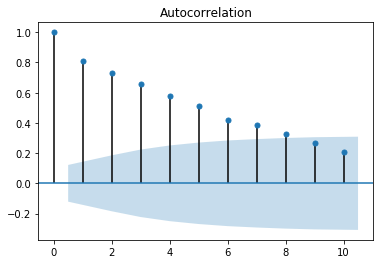

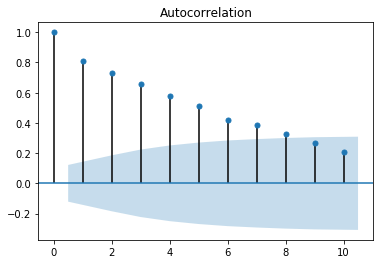

In [43]:
plot_acf(residuals, lags=10)

In [44]:
acorr_ljungbox(residuals, lags=10)

(array([173.10952869, 312.82135636, 428.50407894, 517.94099578,
        587.63554889, 635.36916783, 674.91565695, 703.63282063,
        722.83950012, 734.57376069]),
 array([1.54899313e-039, 1.17952067e-068, 1.48063855e-092, 8.81994458e-111,
        9.48982143e-125, 5.45801358e-134, 1.76246108e-141, 1.18189780e-146,
        8.49197385e-150, 2.36530757e-151]))

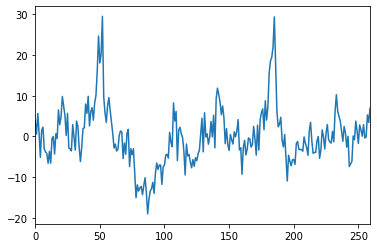

In [45]:
residuals.plot.line()

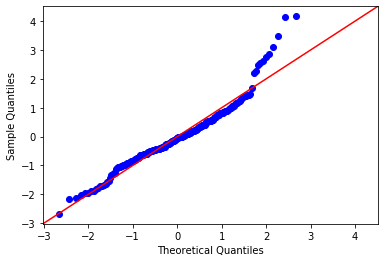

In [46]:
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()

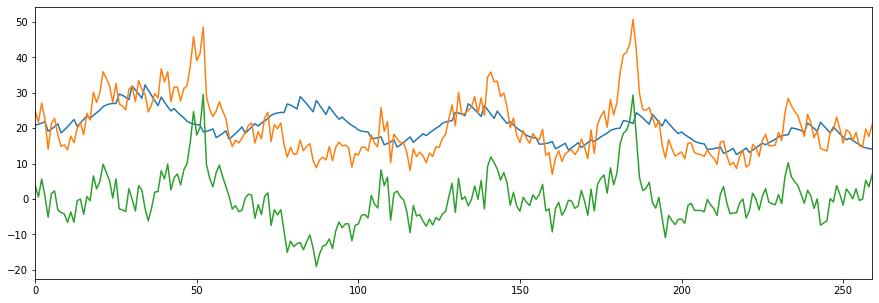

In [47]:
fig, ax = plt.subplots(figsize=(15,5))
results.fittedvalues.plot.line()
train['norm_cases'].plot.line()
residuals.plot.line()

In [48]:
np.sqrt((residuals**2).sum())

114.50324078055745

#### Predict on full dataset

In [49]:
full_data = X.loc[:, variables]
insample = results.predict(full_data)

In [50]:
residuals = X['norm_cases'] - insample

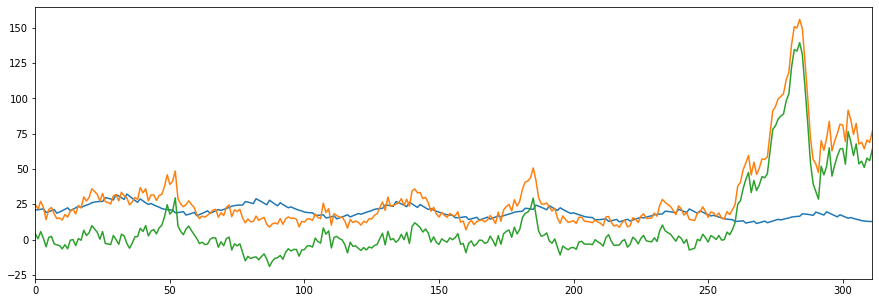

In [51]:
fig, ax = plt.subplots(figsize=(15,5))
insample.plot.line()
X['norm_cases'].plot.line()
residuals.plot.line()

In [52]:
residuals_df = pd.DataFrame({
    'Date':data.loc[data_filter, 'datetime'].tolist(),
    'mean':residuals
})

In [53]:
residuals_df_lm_trig = residuals_df.iloc[1:, ].copy()

#### Try prophet

In [54]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [55]:
prophet_variables = ['datetime', 'norm_cases']

In [56]:
train_prophet = X.loc[X['datetime'] < cutoff, prophet_variables]
test_prophet = X.loc[X['datetime'] >= cutoff, prophet_variables]

In [57]:
train_prophet.columns = ['ds', 'y']

In [58]:
# Fit model
m = Prophet(weekly_seasonality=True)
m.fit(train_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [59]:
# Fitted values
fitted_values = m.predict()

In [60]:
residuals = train_prophet['y'] - fitted_values['yhat']

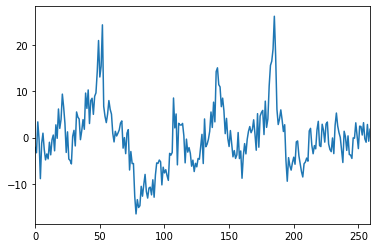

In [61]:
residuals.plot.line()

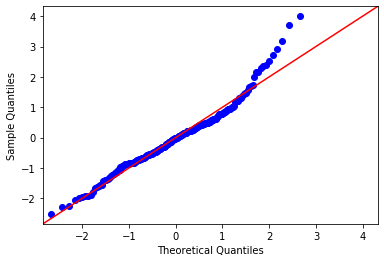

In [62]:
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()

In [63]:
shapiro_wilks_(residuals, alpha=0.05)

Statistics=0.966, p=0.000
Sample does not look Gaussian (reject H0)


In [64]:
jarque_bera_(residuals, alpha=0.05)

Statistics=51.742, p=0.000
Sample does not look Gaussian (reject H0)


In [65]:
statsmodels.stats.stattools.jarque_bera(residuals)

(51.74232071599936,
 5.811628114925645e-12,
 0.6756263613697738,
 4.717652554862991)

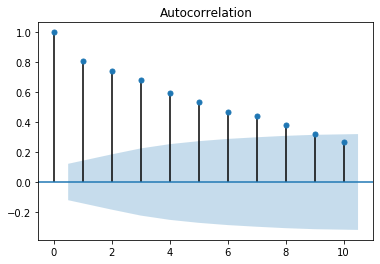

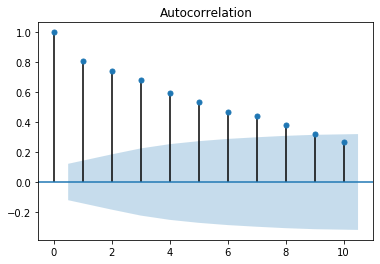

In [66]:
plot_acf(residuals, lags=10)

In [67]:
acorr_ljungbox(residuals, lags=10)

(array([171.15615729, 315.89381048, 438.42113476, 532.55000804,
        608.6124917 , 667.48550316, 720.48839125, 759.58253612,
        787.70587693, 807.59446965]),
 array([4.13671013e-039, 2.53822794e-069, 1.05180016e-094, 6.09808438e-114,
        2.78577282e-129, 6.39382663e-141, 2.63551768e-151, 1.05357802e-158,
        9.41312698e-164, 4.80666627e-167]))

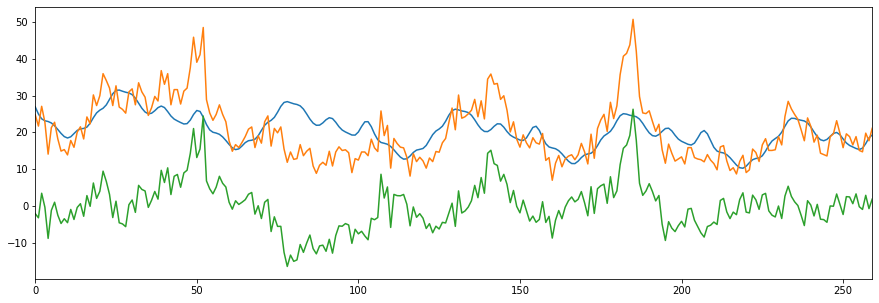

In [68]:
fig, ax = plt.subplots(figsize=(15,5))
fitted_values['yhat'].plot.line()
train['norm_cases'].plot.line()
residuals.plot.line()

In [69]:
np.sqrt((residuals**2).sum())

105.99312254276552

#### Predict on full dataset

In [70]:
full_data = X.loc[:, ['datetime', 'norm_cases']]
full_data.columns = ['ds', 'y']
insample = m.predict(full_data.drop(['y'], axis=1))

In [71]:
residuals = X['norm_cases'] - insample['yhat']

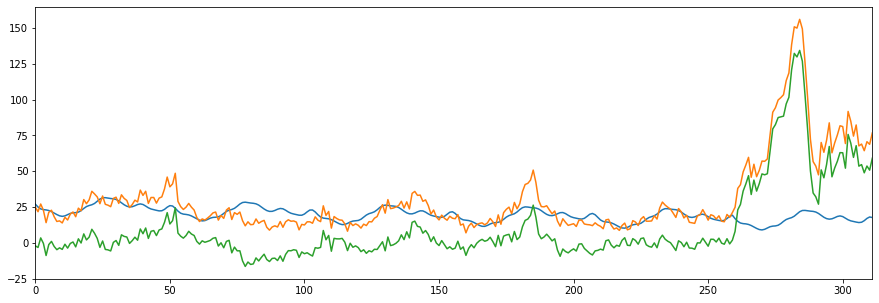

In [72]:
fig, ax = plt.subplots(figsize=(15,5))
insample['yhat'].plot.line()
X['norm_cases'].plot.line()
residuals.plot.line()

In [73]:
residuals_df = pd.DataFrame({
    'Date':data.loc[data_filter, 'datetime'].tolist(),
    'mean':residuals
})

In [74]:
residuals_df_prophet = residuals_df.iloc[1:, ].copy()

#### Try arima

In [75]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [76]:
model = SARIMAX(train['norm_cases'], order=(2,0,0), trend = 'c')
model_fit = model.fit()
print(model_fit.summary())

                           Statespace Model Results                           
Dep. Variable:             norm_cases   No. Observations:                  260
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -725.794
Date:                Sun, 08 Mar 2020   AIC                           1459.589
Time:                        00:33:23   BIC                           1473.831
Sample:                             0   HQIC                          1465.314
                                - 260                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1882      0.668      3.278      0.001       0.880       3.497
ar.L1          0.6689      0.048     13.965      0.000       0.575       0.763
ar.L2          0.2245      0.050      4.462      0.0

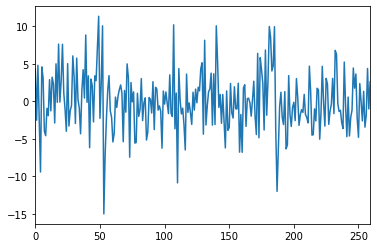

In [77]:
residuals = pd.Series(model_fit.resid)
residuals.plot()

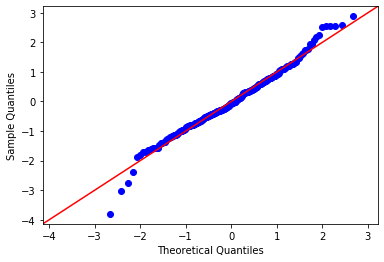

In [78]:
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()

In [79]:
shapiro_wilks_(residuals, alpha=0.05)

Statistics=0.987, p=0.018
Sample does not look Gaussian (reject H0)


In [80]:
jarque_bera_(residuals, alpha=0.05)

Statistics=8.659, p=0.013
Sample does not look Gaussian (reject H0)


In [81]:
statsmodels.stats.stattools.jarque_bera(residuals)

(8.65869494602664,
 0.013176142474089953,
 0.05585958570534355,
 3.887007877982663)

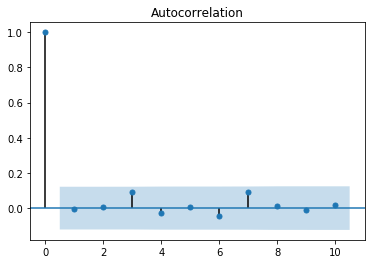

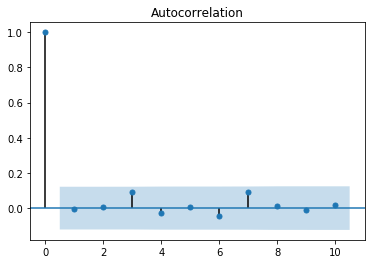

In [82]:
plot_acf(residuals, lags=10)

In [83]:
acorr_ljungbox(residuals, lags=10)

(array([0.01183349, 0.01555911, 2.2298503 , 2.45906971, 2.47978495,
        3.04728745, 5.40145175, 5.45953741, 5.48001095, 5.57007342]),
 array([0.91337554, 0.99225063, 0.52609275, 0.65197968, 0.77953637,
        0.80288879, 0.61109571, 0.70751867, 0.79061981, 0.84999892]))

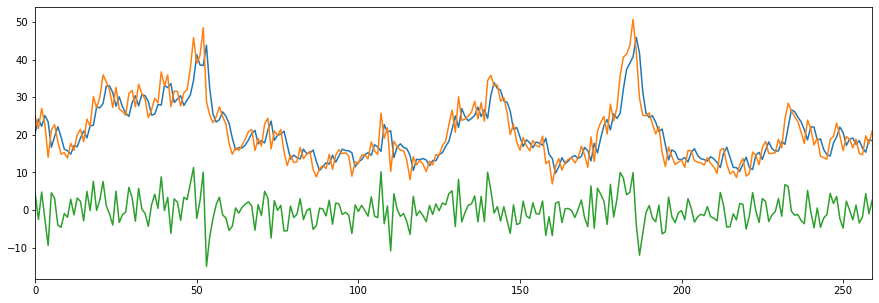

In [84]:
fig, ax = plt.subplots(figsize=(15,5))
model_fit.fittedvalues.plot.line()
train['norm_cases'].plot.line()
residuals.plot.line()

In [85]:
np.sqrt((residuals**2).sum())

63.55244683938205

#### Predict on full dataset

In [86]:
mod = SARIMAX(X['norm_cases'], order=(2,0,0), trend = 'c')
res = mod.filter(model_fit.params)

insample = res.predict()

In [87]:
residuals = X['norm_cases'] - insample

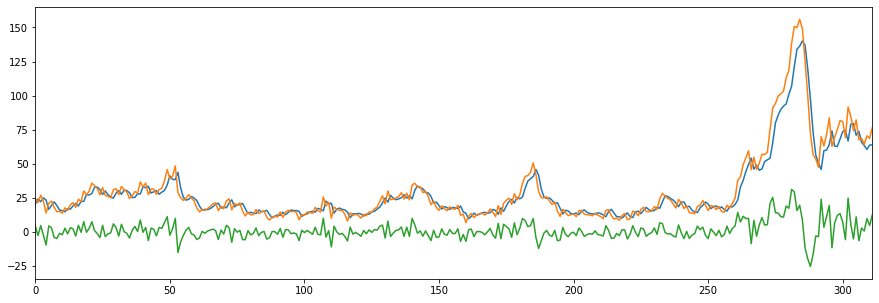

In [88]:
fig, ax = plt.subplots(figsize=(15,5))
insample.plot.line()
X['norm_cases'].plot.line()
residuals.plot.line()

In [89]:
residuals_df = pd.DataFrame({
    'Date':data.loc[data_filter, 'datetime'].tolist(),
    'mean':residuals
})

In [90]:
residuals_df_arima = residuals_df.iloc[1:, ].copy()

#### Rename dataset to fit into functions

In [91]:
data_sub_day = residuals_df_arima.copy()
# data_sub_day = residuals_df_prophet.copy()
# data_sub_day = residuals_df_lm_trig.copy()

In [92]:
# data_sub_day = data.loc[data_filter, :]
# data_sub_day = data_sub_day.filter(['datetime', 'norm_cases'], axis=1).copy()
# data_sub_day.columns = ['Date', 'mean']

In [93]:
in_control_mean = data_sub_day.loc[data_sub_day['Date'] < cutoff, 'mean'].mean()

In [94]:
in_control_mean

-0.035570543255237695

#### Hypothesis test for data (copied from above)

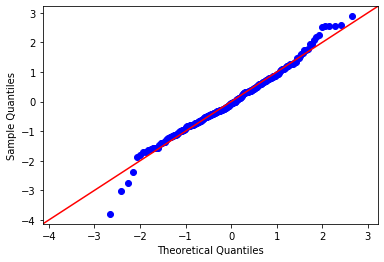

In [95]:
fig = sm.qqplot(data_sub_day.loc[data_sub_day['Date'] < cutoff, 'mean'], fit=True, line='45')
plt.show()

In [96]:
shapiro_wilks_(data_sub_day.loc[data_sub_day['Date'] < cutoff, 'mean'], alpha=0.05)

Statistics=0.987, p=0.016
Sample does not look Gaussian (reject H0)


In [97]:
jarque_bera_(data_sub_day.loc[data_sub_day['Date'] < cutoff, 'mean'], alpha=0.05)

Statistics=8.984, p=0.011
Sample does not look Gaussian (reject H0)


In [98]:
statsmodels.stats.stattools.jarque_bera(data_sub_day.loc[data_sub_day['Date'] < cutoff, 'mean'])

(8.983968675802945,
 0.011198400337380097,
 0.06375863253694795,
 3.9034548427973497)

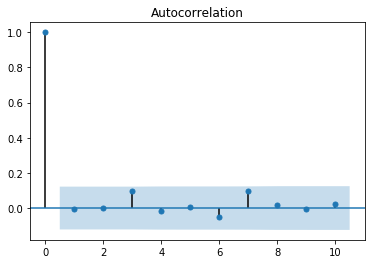

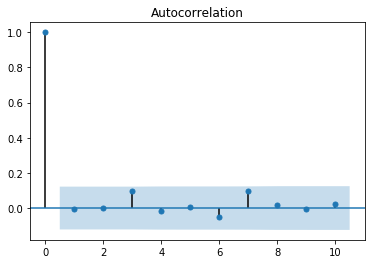

In [99]:
plot_acf(data_sub_day.loc[data_sub_day['Date'] < cutoff, 'mean'], lags=10)

In [100]:
acorr_ljungbox(data_sub_day.loc[data_sub_day['Date'] < cutoff, 'mean'], lags=10)

(array([4.38146942e-03, 4.91624677e-03, 2.35638346e+00, 2.45633569e+00,
        2.46039000e+00, 3.11853053e+00, 5.70498163e+00, 5.80877744e+00,
        5.82493861e+00, 5.93722554e+00]),
 array([0.94722443, 0.9975449 , 0.50180546, 0.65247126, 0.78244824,
        0.79382976, 0.57458796, 0.66864176, 0.75730331, 0.82050941]))

#### Calculate moving range

In [101]:
data_sub_day['MR'] = data_sub_day['mean'].rolling(window=2).apply(lambda x: x.max() - x.min(), raw=True)

In [102]:
data_sub_day.loc[data_sub_day['Date'] < cutoff, 'MR'].mean() / 1.128

3.891855375934335

In [103]:
x_ind_df = data_sub_day.copy()

In [104]:
def x_ind_params(mu0, sigma, length, L=3):
    
    # params
    UCL = mu0 + L * sigma
    center = mu0
    LCL = mu0 - L * sigma
    
    ret = pd.DataFrame({
        'UCL':UCL,
        'Center':center,
        'LCL':LCL
    }, index=list(range(length)))
    
    return ret    

In [105]:
x_ind_params_df = x_ind_params(mu0=in_control_mean, 
                               sigma = x_ind_df.loc[x_ind_df['Date'] < cutoff, 'MR'].mean() / 1.128, 
                               length = len(x_ind_df['mean']))

In [106]:
x_ind_df = pd.concat([x_ind_df.reset_index(drop=True), x_ind_params_df.reset_index(drop=True)], axis=1)

Text(0, 0.5, 'X')

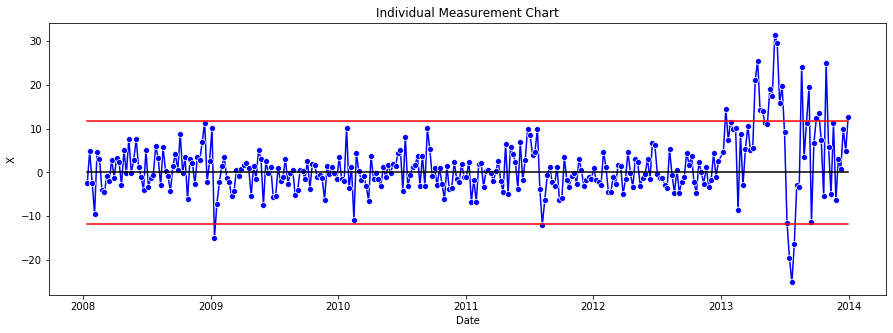

In [107]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='Date', y='mean', data=x_ind_df, kind='line', ax=ax, color='blue', marker='o')
sns.lineplot(x='Date', y='UCL', data=x_ind_df, drawstyle='steps-pre', ax=ax, color='red')
sns.lineplot(x='Date', y='LCL', data=x_ind_df, drawstyle='steps-pre', ax=ax, color='red')
sns.relplot(x='Date', y='Center', data=x_ind_df, kind='line', ax=ax, color='black')
plt.close()
plt.close()
plt.title('Individual Measurement Chart')
plt.ylabel('X')

In [129]:
x_ind_df['Date'][x_ind_df['mean'] > x_ind_df['UCL'][-1:].values[0]].reset_index(drop=True)[0:6]

0   2013-01-14
1   2013-04-08
2   2013-04-15
3   2013-04-22
4   2013-04-29
5   2013-05-20
Name: Date, dtype: datetime64[ns]

In [157]:
x_ind_df2 = x_ind_df.copy()

In [158]:
x_ind_df2['mean'] = x_ind_df2['mean'] + insample
x_ind_df2['UCL'] = x_ind_df2['UCL'] + insample
x_ind_df2['Center'] = x_ind_df2['Center'] + insample
x_ind_df2['LCL'] = x_ind_df2['LCL'] + insample

In [159]:
# x_ind_df2 = x_ind_df2[x_ind_df2['Date'] > '2013-06']

Text(0, 0.5, 'X')

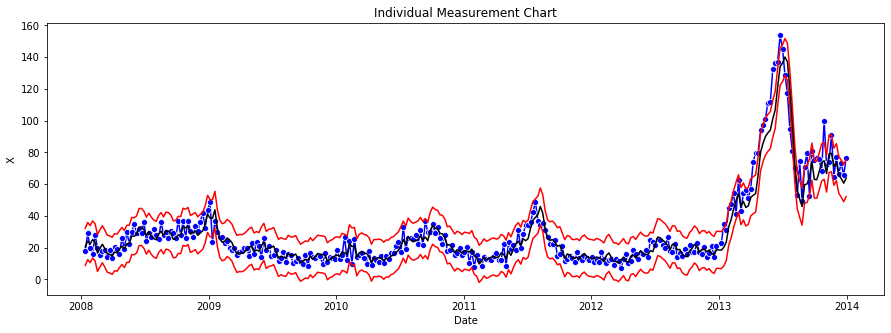

In [160]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='Date', y='mean', data=x_ind_df2, kind='line', ax=ax, color='blue', marker='o')
sns.lineplot(x='Date', y='UCL', data=x_ind_df2, ax=ax, color='red')
sns.lineplot(x='Date', y='LCL', data=x_ind_df2, ax=ax, color='red')
sns.relplot(x='Date', y='Center', data=x_ind_df2, kind='line', ax=ax, color='black')
plt.close()
plt.close()
plt.title('Individual Measurement Chart')
plt.ylabel('X')

#### Calculate EWMA

In [109]:
def ewma(arg, alpha=0.1, mu0=None):
    
    if mu0 is None: 
        arg_temp = arg.copy().tolist()
        
    else:
        arg_temp = arg.copy().tolist()
        arg_temp.insert(0, mu0)
    
    # Convert list to series
    arg_series = pd.Series(arg_temp)
    
    # calculate offset: if mu0=None, offset=0, else offset=1
    offset = len(arg_series) - len(arg)
    
    # Return ewma
    ret = arg_series.ewm(alpha=alpha, adjust=False).mean()[offset:].tolist()
    
    return ret

In [110]:
def ewma_params(mu0, sigma, length, alpha=0.1, L=3):
    
    # Set up the index
    i = pd.Series(list(range(1, length+1)))
    
    # params
    UCL = mu0 + L * sigma * np.sqrt((alpha / (2-alpha)) * (1 - (1-alpha)**(2*i)))
    center = mu0
    LCL = mu0 - L * sigma * np.sqrt((alpha / (2-alpha)) * (1 - (1-alpha)**(2*i)))
    
    ret = pd.DataFrame({
        'UCL':UCL,
        'Center':center,
        'LCL':LCL
    })
    
    return ret

In [111]:
ewma_df = data_sub_day.copy()

In [112]:
ewma_df['ewma'] = ewma(data_sub_day['mean'], mu0=in_control_mean)

In [113]:
ewma_params_df = ewma_params(mu0 = in_control_mean, 
                             sigma = ewma_df.loc[ewma_df['Date'] < cutoff, 'MR'].mean() / 1.128,
                             length=len(ewma_df['mean']))

In [114]:
ewma_df = pd.concat([ewma_df.reset_index(drop=True), ewma_params_df.reset_index(drop=True)], axis=1)

Text(0, 0.5, 'EWMA')

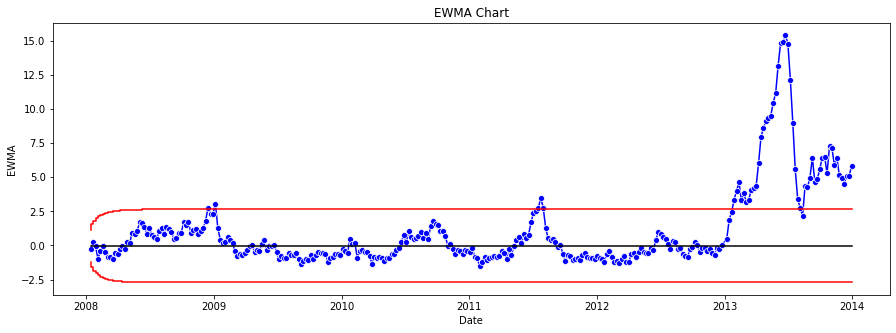

In [115]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='Date', y='ewma', data=ewma_df, kind='line', ax=ax, color='blue', marker='o')
sns.lineplot(x='Date', y='UCL', data=ewma_df, drawstyle='steps-pre', ax=ax, color='red')
sns.lineplot(x='Date', y='LCL', data=ewma_df, drawstyle='steps-pre', ax=ax, color='red')
sns.relplot(x='Date', y='Center', data=ewma_df, kind='line', ax=ax, color='black')
plt.close()
plt.close()
plt.title('EWMA Chart')
plt.ylabel('EWMA')

In [128]:
ewma_df['Date'][ewma_df['ewma'] > ewma_df['UCL'][-1:].values[0]].reset_index(drop=True)[0:8]

0   2008-12-15
1   2009-01-05
2   2011-07-18
3   2011-07-25
4   2011-08-01
5   2013-01-28
6   2013-02-04
7   2013-02-11
Name: Date, dtype: datetime64[ns]

#### Calculate cusum

In [117]:
def cusum(arg, mu0=None):
    
    if mu0 is None: 
        mu0 = arg.mean()
        
    # Calculate deviation
    dev = arg - mu0
    
    # Calculate cusum
    cusum = dev.cumsum()
    
    return cusum

In [118]:
cusum_df = data_sub_day.copy()

In [119]:
cusum_df['cusum'] = cusum(cusum_df['mean'], mu0=in_control_mean)

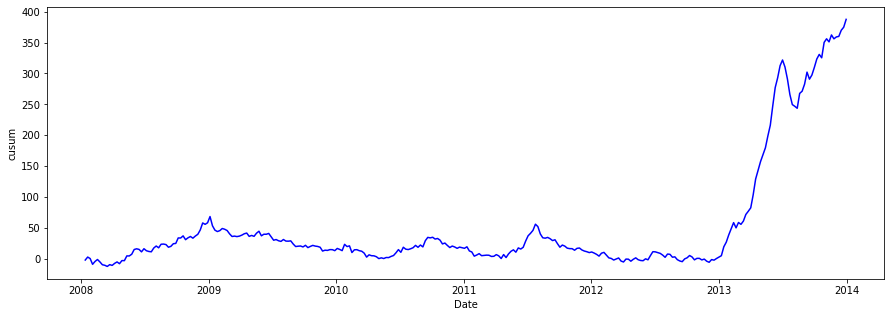

In [120]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='Date', y='cusum', data=cusum_df, kind='line', ax=ax, color='blue')
plt.close()

#### Tabular cusum

In [121]:
def tab_cusum(arg, mu0, sigma, k=0.5, h=4):
    
    # Set up parameters
    K = k * sigma
    H = h * sigma
    
    tol_pos = mu0 + K
    tol_neg = mu0 - K
    
    dev_pos = (arg - tol_pos).tolist()
    dev_neg = (tol_neg - arg).tolist()
    
    C_pos = [0] * (len(arg) + 1)
    C_neg = [0] * (len(arg) + 1)
    
    # Start loop
    for i in range(1, (len(arg) + 1)):

        C_pos[i] = np.max([0, dev_pos[i-1] + C_pos[i-1]])
        C_neg[i] = np.max([0, dev_neg[i-1] + C_neg[i-1]])
    
    ret = pd.DataFrame({
        'C_pos':C_pos,
        'C_neg':C_neg,
        'UCL':H
    })
    
    ret = ret.iloc[1:, ]
    ret['C_neg'] = -1 * ret['C_neg']
    ret['LCL'] = -1 * ret['UCL']
#     ret['xi'] = arg.tolist()
    
    return(ret)

In [122]:
tab_cusum_df = data_sub_day.copy()

In [123]:
tab_cusum_params_df = tab_cusum(tab_cusum_df['mean'], 
                                mu0=in_control_mean, 
                                sigma=tab_cusum_df.loc[tab_cusum_df['Date'] < cutoff, 'MR'].mean() / 1.128)

In [124]:
tab_cusum_df = pd.concat([tab_cusum_df.reset_index(drop=True), tab_cusum_params_df.reset_index(drop=True)], axis=1)

Text(0, 0.5, 'Cusum')

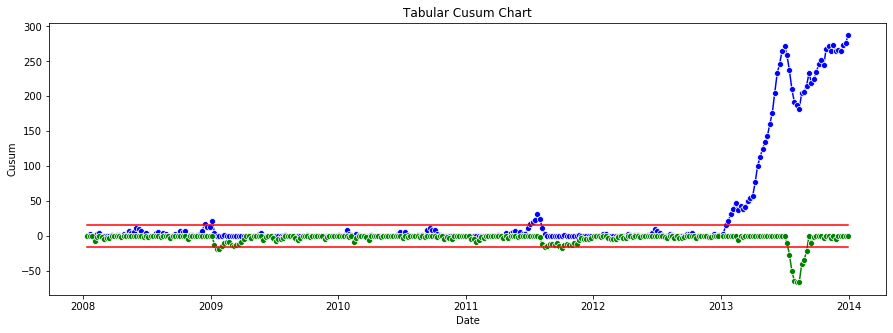

In [125]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='Date', y='C_pos', data=tab_cusum_df, kind='line', ax=ax, color='blue', marker='o')
sns.relplot(x='Date', y='C_neg', data=tab_cusum_df, kind='line', ax=ax, color='green', marker='o')
sns.lineplot(x='Date', y='UCL', data=tab_cusum_df, drawstyle='steps-pre', ax=ax, color='red')
sns.lineplot(x='Date', y='LCL', data=tab_cusum_df, drawstyle='steps-pre', ax=ax, color='red')
plt.close()
plt.close()
plt.title('Tabular Cusum Chart')
plt.ylabel('Cusum')

In [126]:
tab_cusum_df['Date'][tab_cusum_df['C_pos'] > tab_cusum_df['UCL'][-1:].values[0]].reset_index(drop=True)[0]

Timestamp('2008-12-15 00:00:00')